<a href="https://colab.research.google.com/github/Chaudhary-Aakash/DeepLearning/blob/master/Copy_of_Final_year_Project_3try_150ep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
from __future__ import print_function
import numpy as np # For numerical fast numerical calculations
import matplotlib.pyplot as plt # For making plots
import pandas as pd # Deals with data
import seaborn as sns # Makes beautiful plots
import keras 
import sys 
from pandas import pandas as pd
#import category_encoders as ce
import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import os
import glob
import numpy as np
import scipy as sp
import pandas as pd
# skimage
from skimage.io import imshow, imread, imsave
from skimage.transform import rotate, AffineTransform, warp,rescale, resize, downscale_local_mean
from skimage import color,data
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
# imgaug
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
# Albumentations
import albumentations as A 
# Keras
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img 
#visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib inline
import seaborn as sns
from IPython.display import HTML, Image
import cv2
import os
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns

# load data

p_train=pd.read_csv('/content/drive/My Drive/plant-pathology-2020-fgvc7/train.csv')
p_test=pd.read_csv('/content/drive/My Drive/plant-pathology-2020-fgvc7/test.csv')

In [0]:
target = p_train[['healthy', 'multiple_diseases', 'rust', 'scab']]
test_ids = p_test['image_id']

img_size=224

0    1305
1     516
Name: healthy, dtype: int64

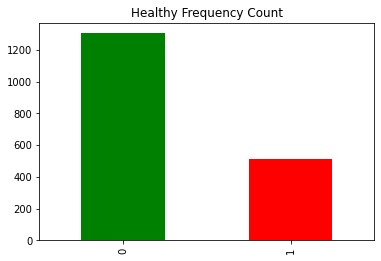

In [0]:
colors=['green','red']
p_train['healthy'].value_counts().plot(kind='bar',title='Healthy Frequency Count',color=colors)
p_train['healthy'].value_counts()

Train Shape: (1821, 224, 224, 3)
Test Shape: (1821, 224, 224, 3)


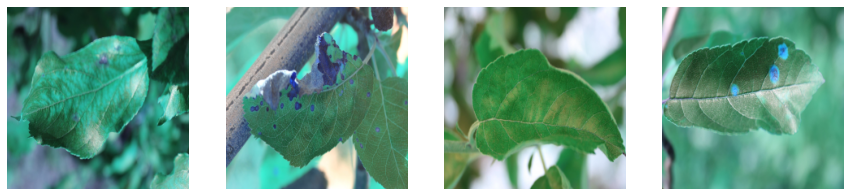

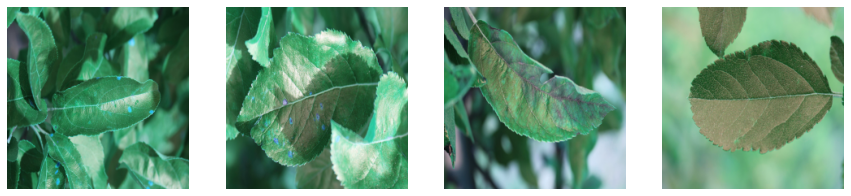

In [0]:
train_image=[]
for name in p_train['image_id']:
    path='/content/drive/My Drive/plant-pathology-2020-fgvc7/images/'+name+'.jpg'
    img=cv2.imread(path)
    image=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_AREA)
    train_image.append(image)

fig, ax = plt.subplots(1, 4, figsize=(15, 15))
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(train_image[i])
    
    
test_image=[]
for name in p_test['image_id']:
    path='/content/drive/My Drive/plant-pathology-2020-fgvc7/images/'+name+'.jpg'
    img=cv2.imread(path)
    image=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_AREA)
    test_image.append(image)
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(test_image[i])    

from keras.preprocessing.image import img_to_array

x_train = np.ndarray(shape=(len(train_image), img_size, img_size, 3),dtype = np.float32)
i=0
for image in train_image:
    x_train[i]=img_to_array(image)
    x_train[i]=train_image[i]
    i=i+1
x_train=x_train/255
print('Train Shape: {}'.format(x_train.shape))

x_test = np.ndarray(shape=(len(test_image), img_size, img_size, 3),dtype = np.float32)
i=0
for image in test_image:
    x_test[i]=img_to_array(image)
    x_test[i]=test_image[i]
    i=i+1
    
x_test=x_test/255
print('Test Shape: {}'.format(x_test.shape))

In [0]:
y = p_train.copy()
del y['image_id']
y.head()

y_train = np.array(y.values)
print(y_train.shape,y_train[0])

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

(1821, 4) [0 0 0 1]


((1456, 224, 224, 3), (365, 224, 224, 3), (1456, 4), (365, 4))

In [0]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state = 115) 
 
x_train, y_train = sm.fit_resample(x_train.reshape((-1, img_size * img_size * 3)), y_train)
x_train = x_train.reshape((-1, img_size, img_size, 3))
x_train.shape, y_train.sum(axis=0)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

((1960, 224, 224, 3), array([490, 490, 490, 490]))

In [0]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
LR_reduce=ReduceLROnPlateau(monitor='val_accuracy',
                            factor=.5,
                            patience=10,
                            min_lr=.000001,
                            verbose=1)

ES_monitor=EarlyStopping(monitor='val_loss',
                          patience=20)

reg = .0005

In [0]:
from keras.models import Model, Sequential, load_model, Input
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.regularizers import l2
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras
from keras import optimizers

model = Sequential()



model.add(Conv2D(32, (3, 3), padding="same",input_shape=(img_size, img_size, 3)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))


model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
  
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
  
model.add(Conv2D(512, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(512, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))



model.add(Flatten())

model.add(Dense(64, input_dim=20, init='uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64, init='uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, init='uniform'))
model.add(Dense(4,activation='softmax'))

model.summary()

from keras.preprocessing.image import ImageDataGenerator

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
activation_12 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 74, 74, 64)        18496     
_________________________________________________________________
activation_13 (Activation)   (None, 74, 74, 64)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, input_dim=20, kernel_initializer="uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, kernel_initializer="uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, kernel_initializer="uniform")`


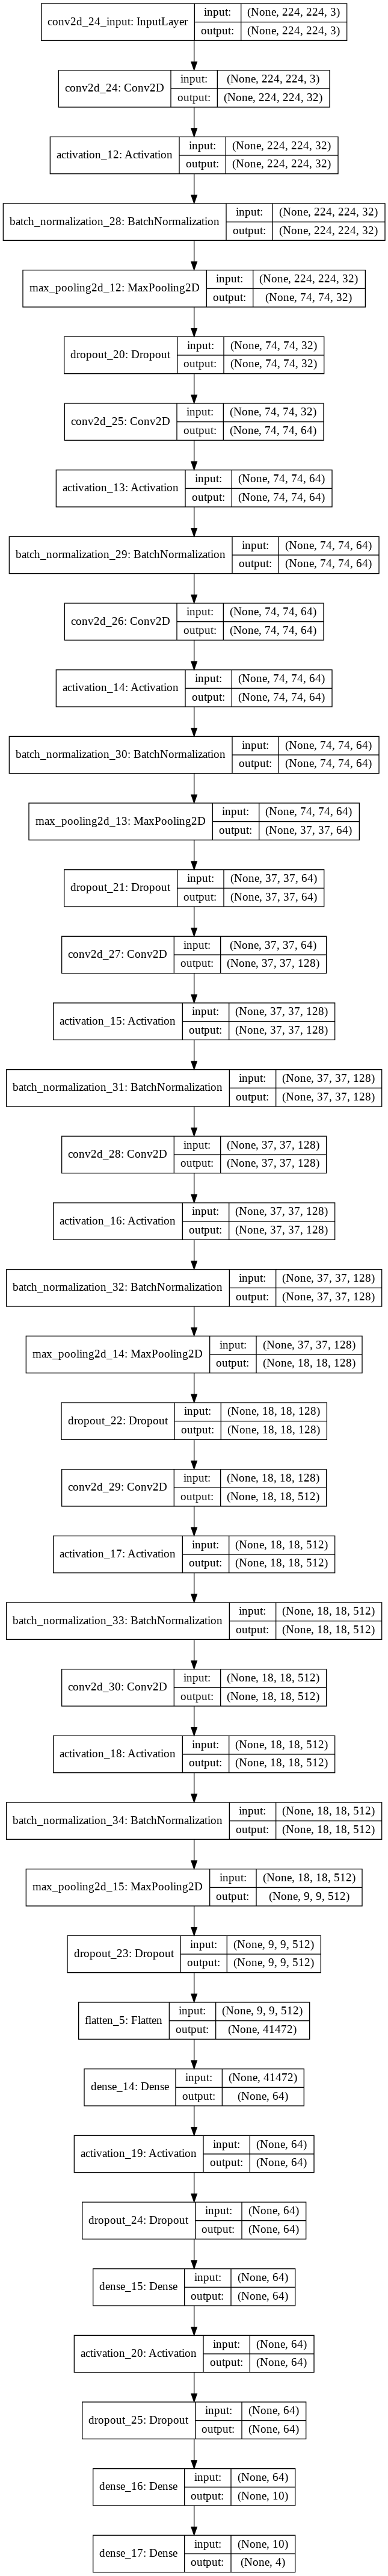

In [0]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [67]:
datagen = ImageDataGenerator(rotation_range=45,
                             shear_range=.25,
                              zoom_range=.25,
                              width_shift_range=.25,
                              height_shift_range=.25,
                              rescale=1/255,
                              brightness_range=[.5,1.5],
                              horizontal_flip=True,
                              vertical_flip=True,
                              fill_mode='nearest'
#                              featurewise_center=True,
#                              samplewise_center=True,
#                              featurewise_std_normalization=True,
#                              samplewise_std_normalization=True,
#                              zca_whitening=True
                              )

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                              epochs=150,
                              steps_per_epoch=x_train.shape[0] // 32,
                              verbose=1,
                              callbacks=[ES_monitor,LR_reduce],
                              validation_data=datagen.flow(x_val, y_val,batch_size=32),
                              validation_steps=x_val.shape[0]//32
                              )

Epoch 1/150
61/61 [==============================] - 38s 622ms/step - loss: 0.4987 - accuracy: 0.8356 - val_loss: 0.4871 - val_accuracy: 0.8892
Epoch 2/150
61/61 [==============================] - 38s 625ms/step - loss: 0.4869 - accuracy: 0.8335 - val_loss: 0.5172 - val_accuracy: 0.8258
Epoch 3/150
61/61 [==============================] - 38s 625ms/step - loss: 0.5502 - accuracy: 0.8086 - val_loss: 0.4799 - val_accuracy: 0.8138
Epoch 4/150
61/61 [==============================] - 38s 621ms/step - loss: 0.5560 - accuracy: 0.8159 - val_loss: 0.3678 - val_accuracy: 0.7958
Epoch 5/150
61/61 [==============================] - 37s 614ms/step - loss: 0.4896 - accuracy: 0.8314 - val_loss: 0.4061 - val_accuracy: 0.9099
Epoch 6/150
61/61 [==============================] - 37s 607ms/step - loss: 0.5144 - accuracy: 0.8288 - val_loss: 0.8444 - val_accuracy: 0.8168
Epoch 7/150
61/61 [==============================] - 37s 604ms/step - loss: 0.4745 - accuracy: 0.8422 - val_loss: 0.3949 - val_accuracy:

In [0]:
model.save('plant_18.h5')

In [0]:
from matplotlib import pyplot as plt

h = history.history

offset = 5
epochs = range(offset, len(h['loss']))

plt.figure(1, figsize=(20, 6))

plt.subplot(121)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(epochs, h['loss'][offset:], label='train')
plt.plot(epochs, h['val_loss'][offset:], label='val')
plt.legend()

plt.subplot(122)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(h[f'accuracy'], label='train')
plt.plot(h[f'val_accuracy'], label='val')
plt.legend()

plt.show()

from sklearn.metrics import roc_auc_score

pred_test = model.predict(x_val)
roc_sum = 0
for i in range(4):
    score = roc_auc_score(y_val[:, i], pred_test[:, i])
    roc_sum += score
    print(f'{score:.3f}')

roc_sum /= 4
print(f'totally:{roc_sum:.3f}')v

In [78]:
pred = model.predict(x_test)

res = pd.DataFrame()
res['image_id'] = test_ids
res['healthy'] = pred.round()[:, 0]
res['multiple_diseases'] = pred.round()[:, 1]
res['rust'] = pred.round()[:, 2]
res['scab'] = pred.round()[:, 3]
res.to_csv('submission18.csv', index=False)
res.head(10)

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.0,0.0,1.0,0.0
1,Test_1,0.0,0.0,1.0,0.0
2,Test_2,0.0,0.0,0.0,1.0
3,Test_3,1.0,0.0,0.0,0.0
4,Test_4,0.0,0.0,1.0,0.0
5,Test_5,1.0,0.0,0.0,0.0
6,Test_6,1.0,0.0,0.0,0.0
7,Test_7,0.0,0.0,0.0,1.0
8,Test_8,0.0,0.0,0.0,1.0
9,Test_9,0.0,0.0,1.0,0.0


[[1. 0. 0. 0.]]


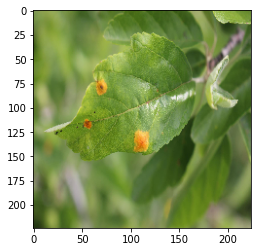

In [76]:
from keras.preprocessing import image
img = image.load_img("/content/drive/My Drive/plant-pathology-2020-fgvc7/images/Train_1070.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

output = model.predict(img)
print(output.round())
